# Sentiment Analysis for Consumer Reviews of Amazon Products

In [1]:
# modules we'll use

import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.utils import resample
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# 1- Geting the Dataset

In [2]:
data = pd.read_csv('reviews.csv')

/home/karim/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 2- Data Preprocessing

In [3]:
data = data[['reviews.text', 'reviews.rating']]

In [4]:
data.rename(columns={'reviews.text':'text', 'reviews.rating':'rating'}, inplace=True)

In [5]:
data.head()

,text,rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [6]:
data.isnull().sum()

text       1
rating    33
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
data.isnull().sum()

text      0
rating    0
dtype: int64

In [9]:
data.rating.value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: rating, dtype: int64

In [10]:
data.shape

(34626, 2)

In [11]:
data.rating = data.rating.map({1:0, 2:0, 3:0, 4:1, 5:1})

In [12]:
data.rating.value_counts()

1    32315
0     2311
Name: rating, dtype: int64

**Convert all text to lower case**

In [13]:
data.text = data['text'].str.lower()

**Tokenization and Lemmatization**

In [14]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"[a-zA-Z']+")

In [15]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [16]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]

In [17]:
data.text = data.text.apply(lemmatize_text)

In [18]:
data.head()

,text,rating
0,"[this, product, so, far, ha, not, disappointed...",1
1,"[great, for, beginner, or, experienced, person...",1
2,"[inexpensive, tablet, for, him, to, use, and, ...",1
3,"[i've, had, my, fire, hd, two, week, now, and,...",1
4,"[i, bought, this, for, my, grand, daughter, wh...",1


**Remove stop words**

In [19]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/karim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
not_stop_words = ['not',"don't","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","shan't","shouldn't","wasn't","weren't","won't","wouldn't"]

In [21]:
stop_words = [x for x in stop_words if (x not in not_stop_words)]

In [22]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [23]:
def remove_stops(row):
    return [w for w in row if not w in stop_words]

In [24]:
data.text = data.text.apply(remove_stops)

In [25]:
def rejoin_words(row):
    return (" ".join(row))

In [26]:
data.text = data.text.apply(rejoin_words)

In [27]:
data.head()

,text,rating
0,product far ha not disappointed child love use...,1
1,great beginner experienced person bought gift ...,1
2,inexpensive tablet use learn step nabi wa thri...,1
3,i've fire hd two week love tablet great value ...,1
4,bought grand daughter come visit set user ente...,1


# -------------------------------------------------------------------------------------------------------------

## Select a model and train it

In [28]:
def confusion_mat(predictions, labels):
    """
    predictor : Predictor object of model
    features: Input features to model
    label: Ground truth target values
    """

    accuracy = (predictions == labels).sum() / labels.shape[0]
    print(f'Accuracy: {accuracy}')
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average = 'binary')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')
    
    confusion_matrix = pd.crosstab(index=labels, columns=predictions, rownames=['Actual'], colnames=['Predicted']).astype(int)
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap="YlGnBu").set_title('Confusion Matrix') 

**Spliting the Data**

In [29]:
data = data.sample(frac=1).reset_index(drop=True)

class_0 = data[data.rating==0]
class_1 = data[data.rating==1]

testset = pd.concat([class_0[:500], class_1[:500]])
trainset = pd.concat([class_0[500:], class_1[500:]])

X_train, X_test, Y_train, Y_test = trainset.text, testset.text, trainset.rating, testset.rating

In [30]:
Y_train.value_counts()

1    31815
0     1811
Name: rating, dtype: int64

In [31]:
Y_test.value_counts()

0    500
1    500
Name: rating, dtype: int64

## Trying Count Vectorizer

In [32]:
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize)
train_features = vectorizer.fit_transform(X_train)

In [33]:
test_features = vectorizer.transform(X_test)

In [34]:
sm = SMOTE(random_state=5)
train_features, Y_train1 = sm.fit_resample(train_features, Y_train)

In [35]:
Y_train1.value_counts()

0    31815
1    31815
Name: rating, dtype: int64

## Naive Bayes

In [36]:
MNB = MultinomialNB()
MNB.fit(train_features, Y_train1)

MultinomialNB()

In [37]:
MNB_train_predictions = MNB.predict(train_features)

Accuracy: 0.8912305516265913
Precision: 0.8773419026253562
Recall: 0.9096338205249096
F1_score: 0.893196092652891


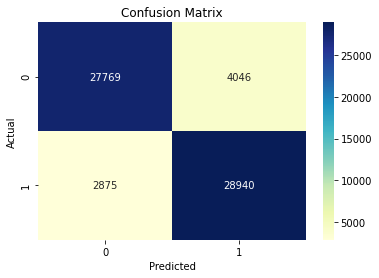

In [38]:
confusion_mat(MNB_train_predictions, Y_train1)

In [39]:
MNB_test_predictions = MNB.predict(test_features)

Accuracy: 0.716
Precision: 0.6574344023323615
Recall: 0.902
F1_score: 0.760539629005059


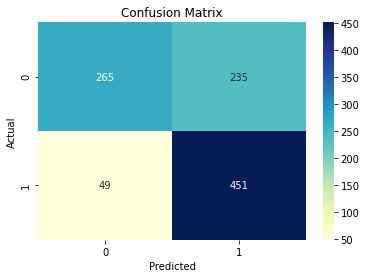

In [40]:
confusion_mat(MNB_test_predictions, Y_test)

## XGBoost Classifier

In [41]:
xgb= XGBClassifier()
xgb.fit(train_features, Y_train1)

/home/karim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
xgb_train_predictions = xgb.predict(train_features)

Accuracy: 0.9764419299072764
Precision: 0.9565112637031683
Recall: 0.9982712556969983
F1_score: 0.976945200633661


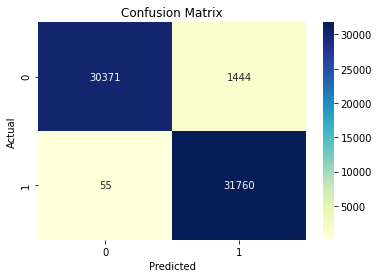

In [43]:
confusion_mat(xgb_train_predictions, Y_train1)

In [44]:
xgb_test_predictions = xgb.predict(test_features)

Accuracy: 0.571
Precision: 0.5384615384615384
Recall: 0.994
F1_score: 0.6985242445537596


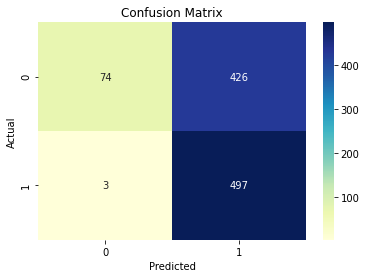

In [45]:
confusion_mat(xgb_test_predictions, Y_test)

# -------------------------------------------------------------------------------------------------------------

## Trying Term Frequencies Vectorizer

In [46]:
vectorizer2 = TfidfVectorizer(use_idf=False, tokenizer=tokenizer.tokenize)
train_features2 = vectorizer2.fit_transform(X_train)

In [47]:
test_features2 = vectorizer2.transform(X_test)

In [48]:
sm2 = SMOTE(random_state=5)
train_features2, Y_train2 = sm2.fit_resample(train_features2, Y_train)

In [49]:
Y_train2.value_counts()

0    31815
1    31815
Name: rating, dtype: int64

## Naive Bayes

In [50]:
MNB2 = MultinomialNB()
MNB2.fit(train_features2, Y_train2)

MultinomialNB()

In [51]:
MNB2_train_predictions = MNB2.predict(train_features2)

Accuracy: 0.8738173817381738
Precision: 0.8880007829831659
Recall: 0.8555398396982555
F1_score: 0.8714681351753727


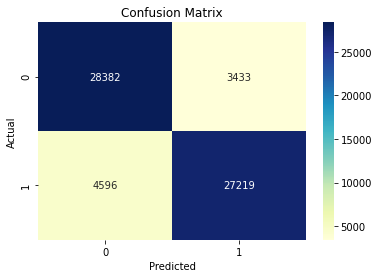

In [52]:
confusion_mat(MNB2_train_predictions, Y_train2)

In [53]:
MNB2_test_predictions = MNB2.predict(test_features2)

Accuracy: 0.8
Precision: 0.7862595419847328
Recall: 0.824
F1_score: 0.8046875


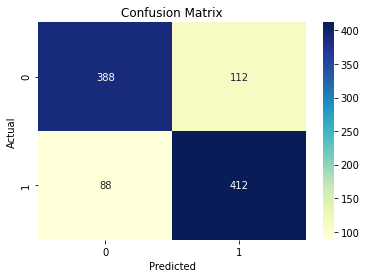

In [54]:
confusion_mat(MNB2_test_predictions, Y_test)

## XGBoost Classifier

In [55]:
xgb2= XGBClassifier()
xgb2.fit(train_features2, Y_train2)

/home/karim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
xgb2_train_predictions = xgb2.predict(train_features2)

Accuracy: 0.9596259625962597
Precision: 0.9489438781775759
Recall: 0.9715228665723715
F1_score: 0.9601006414338299


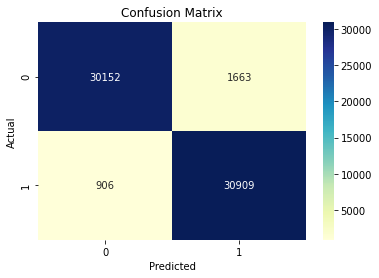

In [57]:
confusion_mat(xgb2_train_predictions, Y_train2)

In [58]:
xgb2_test_predictions = xgb2.predict(test_features2)

Accuracy: 0.67
Precision: 0.6115485564304461
Recall: 0.932
F1_score: 0.7385103011093503


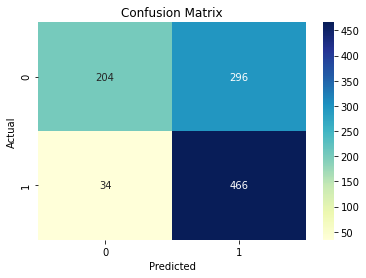

In [59]:
confusion_mat(xgb2_test_predictions, Y_test)

# -------------------------------------------------------------------------------------------------------------

## Trying Term Freq. - Inverse Document Freq. Vectorizer

In [60]:
vectorizer3 = TfidfVectorizer(tokenizer=tokenizer.tokenize)
train_features3 = vectorizer3.fit_transform(X_train)

In [61]:
test_features3 = vectorizer3.transform(X_test)

In [62]:
sm3 = SMOTE(random_state=5)
train_features3, Y_train3 = sm3.fit_resample(train_features3, Y_train)

In [63]:
Y_train3.value_counts()

0    31815
1    31815
Name: rating, dtype: int64

## Naive Bayes

In [64]:
MNB3 = MultinomialNB()
MNB3.fit(train_features3, Y_train3)

MultinomialNB()

In [65]:
MNB3_train_predictions = MNB3.predict(train_features3)

Accuracy: 0.8906962124783907
Precision: 0.9075944386149003
Recall: 0.8699669966996699
F1_score: 0.888382468585001


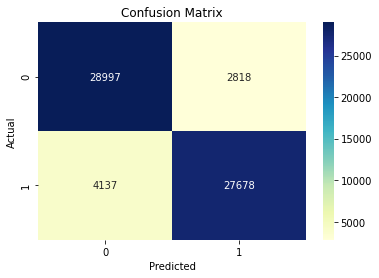

In [66]:
confusion_mat(MNB3_train_predictions, Y_train3)

In [67]:
MNB3_test_predictions = MNB3.predict(test_features3)

Accuracy: 0.783
Precision: 0.755877034358047
Recall: 0.836
F1_score: 0.7939221272554606


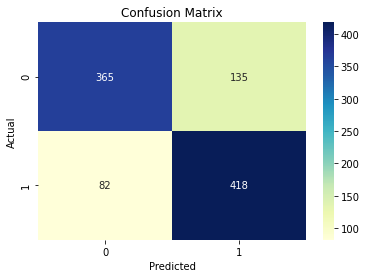

In [68]:
confusion_mat(MNB3_test_predictions, Y_test)

## XGBoost Classifier

In [69]:
xgb3 = XGBClassifier()
xgb3.fit(train_features3, Y_train3)

/home/karim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:13:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
xgb3_train_predictions = xgb3.predict(train_features3)

Accuracy: 0.9567185289957567
Precision: 0.944344209657197
Recall: 0.9706427785635706
F1_score: 0.9573129146258292


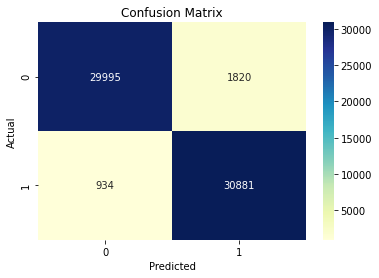

In [71]:
confusion_mat(xgb3_train_predictions, Y_train3)

In [72]:
xgb3_test_predictions = xgb3.predict(test_features3)

Accuracy: 0.687
Precision: 0.6241699867197875
Recall: 0.94
F1_score: 0.7501995211492419


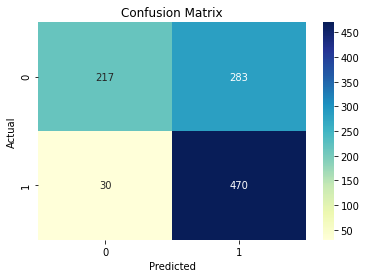

In [73]:
confusion_mat(xgb3_test_predictions, Y_test)